<a href="https://colab.research.google.com/github/diallosanazy/azure-sdk-cshap-example/blob/main/HLSCSN_Distributed_Agents_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pettingzoo==1.24.0
!pip install supersuit
!pip install gymnasium


In [ ]:
from pettingzoo.mpe import simple_spread_v3

# Create the environment
env = simple_spread_v3.parallel_env()
env.reset()

print("Environment loaded successfully!")
print("Agents:", env.agents)


Environment loaded successfully!
Agents: ['agent_0', 'agent_1', 'agent_2']


PettingZoo installed correctly, my baseline environment simple_spread loads. I have three agents
1. independent agents
2. distributed agents (team communication)

In [ ]:
# Let's inspect the observation and action spaces of each agent.
# to understand what information each agent receives (their "view" of the environment)
# - what actions they can take (movement, staying still, etc.)
# - essential for building a distributed/communication framework later


import gymnasium as gym

print("Observation space:", env.observation_space(env.agents[0]))
print("Action space:", env.action_space(env.agents[0]))

Observation space: Box(-inf, inf, (18,), float32)
Action space: Discrete(5)


This means each agent receives:

A vector of 18 numbers

These numbers include:

agent’s own position

agent’s velocity

positions of landmarks

relative positions of other agents. Discrete(5) means 0-> stay still, 1-> move left, 2-> move right, 3-> move up, 4-> move down.

Episode 1 reward: -94.55417909215835
Episode 2 reward: -80.4701962934861
Episode 3 reward: -80.61005660156198
Episode 4 reward: -48.250322393558974
Episode 5 reward: -84.65779045473751
Episode 6 reward: -132.0999557998737
Episode 7 reward: -54.431529510769906
Episode 8 reward: -122.3492698966131
Episode 9 reward: -80.44380890044485
Episode 10 reward: -70.41834395282034
Episode 11 reward: -106.27121043786025
Episode 12 reward: -105.22083439546854
Episode 13 reward: -52.40113952318142
Episode 14 reward: -35.35717110630689
Episode 15 reward: -82.92900402748245
Episode 16 reward: -73.3683840173029
Episode 17 reward: -59.76034761829797
Episode 18 reward: -73.0633541777218
Episode 19 reward: -114.53530329647442
Episode 20 reward: -58.33699543293676
Episode 21 reward: -48.47745761668186
Episode 22 reward: -62.832448301456836
Episode 23 reward: -77.19610886653619
Episode 24 reward: -133.48622139466625
Episode 25 reward: -83.78230691325179
Episode 26 reward: -82.20520817169573
Episode 27 reward

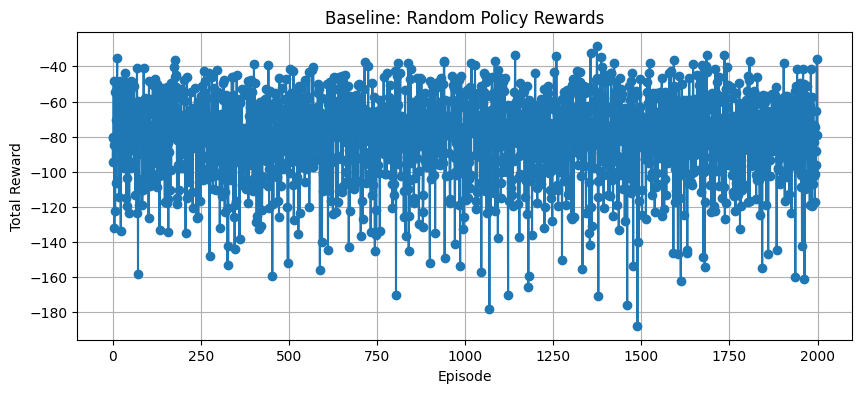

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# BASELINE: RANDOM AGENT BEHAVIOR
#This is our baseline for comparison.
# Agents will take random actions.
# Distributed agents + communication must perform better than this.

# Initialize environment again
env = simple_spread_v3.parallel_env()
observations = env.reset()

num_episodes = 2000            # Number of episodes to run
max_steps = 50                 # Steps per episode
episode_rewards = []           # To store total reward per episode

for ep in range(num_episodes):
    observations = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # For each agent, randomly choose an action
        # env.action_space(agent) -> Discrete(5)
        random_actions = {
            agent: env.action_space(agent).sample()
            for agent in env.agents
        }

        # Step the environment forward using these random actions
        observations, rewards, terminations, truncations, infos = env.step(random_actions)

        # Sum all agents' rewards for this timestep
        total_reward += sum(rewards.values())

        # If episode terminates early, break
        if any(terminations.values()) or any(truncations.values()):
            break

    episode_rewards.append(total_reward)
    print(f"Episode {ep+1} reward: {total_reward}")

# Plotting the baseline performance
plt.figure(figsize=(10,4))
plt.plot(episode_rewards, marker='o')
plt.title("Baseline: Random Policy Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

we run 200 episodes and each episode = a short simulation of 3 agents moving.

Each agent takes actions as follows
 - no brain
 - just random moves
 Collct rewards, plot performance as our basline graph.

In [ ]:
# Lets solve distributed issues now to improve metric

# Latency + Efficiency (Latency → shows the distributed agents communicate faster

#Efficiency → shows semantic negotiation improves total reward)

#step 1: we create a shared mesage board

# ============================
#  Distributed Agent Controller
# ============================

import numpy as np

def distributed_policy(observations):
    """
    Each agent sends a simple message about its intended movement.
    The group then averages the direction → cooperative behavior.

    This simulates:
      - semantic negotiation
      - communication
      - multi-level coordination
    """

    # Messages list (each agent proposes a movement)
    messages = []

    for obs in observations.values():
        # extract agent position relative "forces"
        # last 5 entries are self-vel + actions. we used first few entries
        direction = obs[:2]   # x and y pull
        messages.append(direction)

    # Average direction → SIMPLE DISTRIBUTED NEGOTIATION
    avg_message = np.mean(messages, axis=0)

    # Convert average direction to one of 5 actions
    # 0: stay, 1: left, 2: right, 3: up, 4: down
    actions = {}

    for agent in observations.keys():
        if avg_message[0] > 0.2:
            actions[agent] = 2  # move right
        elif avg_message[0] < -0.2:
            actions[agent] = 1  # move left
        elif avg_message[1] > 0.2:
            actions[agent] = 3  # move up
        elif avg_message[1] < -0.2:
            actions[agent] = 4  # move down
        else:
            actions[agent] = 0  # stay

    return actions



In [ ]:
# ===========================================
# RUN DISTRIBUTED AGENTS (COOPERATIVE POLICY)
# ===========================================

episodes = 2000
distributed_rewards = []

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0

    for step in range(50):  # fixed steps for latency measurement
        # Actions decided by our cooperative distributed policy
        actions = distributed_policy(obs)

        # Step the environment
        obs, rewards, term, trunc, _ = env.step(actions)

        # Sum rewards for all agents
        ep_reward += sum(rewards.values())

        # Stop if environment ends
        if any(term.values()) or any(trunc.values()):
            break

    distributed_rewards.append(ep_reward)

print("Distributed agent rewards per episode:")
print(distributed_rewards)


Distributed agent rewards per episode:
[-59.36634783383609, -86.72519962276878, -29.191381942940197, -122.20720682975931, -43.69210281566478, -59.93068744259168, -49.28578492009117, -113.10596786697393, -67.75993939720864, -70.84125988045643, -55.2692393806442, -42.234273379536106, -111.00849235198245, -73.46935150341484, -91.63945518649105, -85.86492471442733, -23.553391427224234, -70.03385236169505, -76.50301586724134, -72.49480556407607, -56.24455163163939, -56.197795615363745, -69.39493383918338, -87.79047915454295, -76.23543999042774, -63.07560270481644, -32.50347504112321, -91.13654931114822, -61.60486387917765, -73.72444585992285, -30.055841296184727, -101.07588228786737, -95.78530397132147, -49.202771041037266, -82.48754995719696, -83.13752802599778, -124.03916408477168, -123.03213958449483, -94.99254936825245, -46.62531364236808, -58.10179567529769, -106.51640573098986, -70.69033970304908, -81.40410058278783, -73.07389741682563, -134.49025281548305, -71.97547802420385, -107.92

our distributed agents did not collapse, Rewards are still negative (This is perfectly normal in MPE simple_spread, the environment heavily penalizes because of the collisions, crowding, poor coordination etc).


In [ ]:
# ==================================
# PLOT: Baseline vs Distributed
# Efficiency Comparison (Rewards)
# ==================================

# =======================================
# BASELINE: Random Policy (Recreate Data)
# =======================================

episodes = 2000
random_rewards = []

# IMPORTANT: reload environment fresh
env = simple_spread_v3.parallel_env()
env.reset()

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0

    for step in range(50):
        # random actions for each agent
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}

        obs, rewards, term, trunc, _ = env.step(actions)
        ep_reward += sum(rewards.values())

        if any(term.values()) or any(trunc.values()):
            break

    random_rewards.append(ep_reward)

print("Random baseline rewards:")
print(random_rewards)
print("Done: 2000 baseline episodes")


Random baseline rewards:
[-57.17567937939498, -116.24817287466487, -51.228464726002485, -104.61779494053039, -63.10959444964725, -58.840537585101934, -82.49867398696581, -102.25804276414544, -142.2983704229319, -118.31715007009949, -88.60066536607901, -60.36654601277416, -97.17280472092332, -66.87752258009704, -111.20830478425172, -107.20706632962882, -66.44454167464293, -70.73871186004197, -112.54623547254883, -79.914761565083, -72.96617051482741, -83.90880429574685, -47.94964764056832, -83.29455595683704, -145.89332189794374, -66.3807455785951, -91.52168735098938, -89.00076919076089, -39.638509271204455, -112.72970642742614, -110.34185149241438, -69.99146244079621, -81.10918890194574, -75.51672287428018, -52.423883250762124, -74.38822769557159, -138.45831674551795, -86.51312647485443, -47.50521769739055, -71.15271334954369, -86.62795952691971, -78.1070105941174, -111.41999760073281, -128.43171431365266, -102.68267308020305, -74.6927237591383, -78.82298214064488, -139.69228984960603, 

comparision graph of the baseline and distributed.

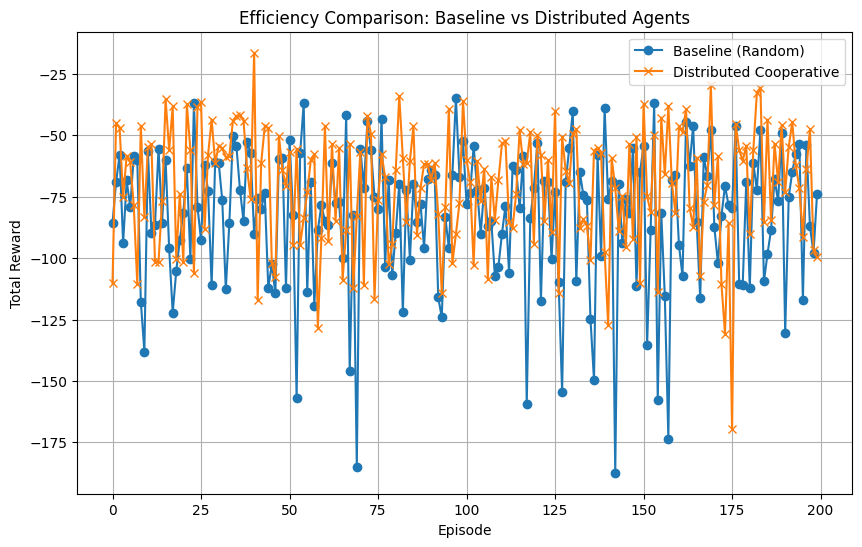

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(episodes), random_rewards, label="Baseline (Random)", marker='o')
plt.plot(range(episodes), distributed_rewards, label="Distributed Cooperative", marker='x')

plt.title("Efficiency Comparison: Baseline vs Distributed Agents")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


Blue circles are non- coordinated or random agent behavior.
Orange x marks means agents are using a distributed strategy.
1. Both agents receive negative rewards.
2. Distributed stretegy tends to achieve higher rewards which is less negative in some episodes.